In [69]:
from dm_control import suite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
import random
import time
import numpy as np
from matplotlib import pyplot as plt

In [70]:
print(tf.__version__)

2.2.0


In [71]:
# Swimmer6 snake , task: get to the goal 
# env = suite.load(domain_name="cartpole", task_name="swingup")
env = suite.load(domain_name="cartpole", task_name="balance")

In [72]:
def save_models(agent):
    agent.critic_model.save('Car/critic_model.h5')
    agent.actor_model.save('Car/actor_model.h5')
    agent.target_critic_model.save('Car/target_critic_model.h5')
    agent.target_actor_model.save('Car/target_actor_model.h5')
    
def save_scores(scores,last_rewards,first_rewards):
    np.savetxt('Car/scores.csv', scores)
    np.savetxt('Car/last_rewards.csv', last_rewards)
    np.savetxt('Car/first_rewards.csv', first_rewards) 

In [73]:
print(env.observation_spec())

OrderedDict([('position', Array(shape=(3,), dtype=dtype('float64'), name='position')), ('velocity', Array(shape=(2,), dtype=dtype('float64'), name='velocity'))])


In [74]:
# to change all layers to have dtype float64 by default
tf.keras.backend.set_floatx('float32')

In [75]:
def convert_state(obs):
#     obs = np.hstack(
#         [obs['joints'], obs['to_target'], obs['body_velocities']]
#     ).reshape((1,25))  # all of the components: joints, to_target, body_velocities sum up to 25
#     return np.reshape(obs, (1, 25))
    list1 = [i.tolist() for i in list(obs.values())]
    list2 = np.array([])
    for sublist in list1:
        list2 = np.append(list2, sublist)
    return np.reshape(list2, (1,5))

In [77]:
class DDPG(object):
    
    def __init__(self, state_dim, action_spec, discount_rate,tau, batch_size):
        self.action_spec = action_spec
        self.state_dim = state_dim
        self.action_dim = self.action_spec.shape[0]
        self.action_min = self.action_spec.minimum
        self.action_max = self.action_spec.maximum
        self.actor_opt = tf.optimizers.Adam(1e-3)   
        self.discount_rate = discount_rate
        self.batch_size = batch_size
        self.noise_scale = 1.0
        self.tau = tau
        
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
            }

        # Actor Network
        self.actor_model = self.create_actor_model()

        #Create target actor as clone of actor
        self.target_actor_model = clone_model(self.actor_model)
        self.target_actor_model.compile(optimizer='sgd', loss='mse')
               
        # Critic Network
        self.critic_model = self.create_critic_model()
        
        #Create target critic as clone of critic
        self.target_critic_model = clone_model(self.critic_model)
        self.target_critic_model.compile(optimizer='sgd', loss='mse')
        

    def create_actor_model(self):
        #Create actor
        actor_model = tf.keras.Sequential([
        # Add 400 layer with relu on observations input
        layers.Dense(400, activation='relu', input_shape=(self.state_dim,)),
        # Add 300 hidden layer
        layers.Dense(300, activation='relu'),
        # Add output action layer with tanh as need 5 size array with -1 to 1 values
        layers.Dense(self.action_dim, activation='tanh')])

        # config the model with losses and metrics
        actor_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
        return actor_model
    
    def create_critic_model(self):
        #Create critic 
        #Add inputs observations and actions
        action_input = tf.keras.Input(shape=(self.action_dim,), name='action')
        observation_input = tf.keras.Input(shape=self.state_dim, name='state')
        flattened_observation = layers.Flatten()(observation_input)
        #Add layer on observation input only
        l=layers.Dense(400, activation='relu', input_shape=(self.state_dim,))(flattened_observation)
        #Later add actions
        l=layers.Concatenate()([l, action_input])
        l=layers.Dense(300, activation='relu')(l)
        #Output q value
        l=layers.Dense(1, activation='linear')(l)
        critic_model = tf.keras.Model(inputs=[action_input, observation_input], outputs=l)

        # config the model with losses and metrics
        critic_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
        return critic_model
    
    def get_action_with_noise(self, obs):
        #Make action based on determenistic trained policy, but add Gaussian noise to explore env
        action = self.actor_model.predict(obs)[0]
        action = action + self.noise_scale*np.random.normal(0,1,size = self.action_dim)
        action = np.clip(action, -1.0, 1.0)  # between action values
        return action
    
    def update_buffer(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            if self.memory["done"].shape[0]>1000000:
                for key in self.memory.keys():
                    self.memory[key] = self.memory[key][-900000:] #leave only part of buffer
            self.memory["state"] = np.vstack((self.memory["state"], np.array(obs)))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], np.array(new_obs)))
            self.memory["action"] = np.vstack((self.memory["action"], action))
        else: 
            # if not initialized new
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
            self.memory["action"] = np.array(action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)  # not cleaning, always not empty
        self.memory["done"] = np.append(self.memory["done"], done)
        
#     @tf.function  
    def ddpg_batch_update(self):
        if self.memory["done"].shape[0]>=self.batch_size: #there is enough for sampling
            indexes = random.sample(range(0, self.memory["done"].shape[0]), self.batch_size)
            batch = {
                    "state": np.squeeze(self.memory["state"][indexes]), 
                    "action": np.squeeze(self.memory["action"][indexes]), 
                    "reward": self.memory["reward"][indexes], 
                    "new_state": np.squeeze(self.memory["new_state"][indexes]), 
                    "done": self.memory["done"][indexes]
                    }
            
            # Q' in DDPG pseudocode to count target critic value using only target networks,
            #based on new state choose action by target actor deterministic 
            #and count q value based on new state and chosen action by target critic 
            target_q = self.target_critic_model({"state":batch["new_state"], 
                                            "action": self.target_actor_model(batch["new_state"])})
            # y_i in DDPG  , target value to count MSE: ri+ discount_rate*Q_target 
            # if done do not add future reward, so added  *(1-batch["done"])
            y = batch["reward"].reshape(self.batch_size,1) + \
                (self.discount_rate*(1-batch["done"])).reshape(self.batch_size,1)*target_q
           
            # update critic by minimizing MSE loss between y and usual critic, actor output
            self.critic_model.train_on_batch({"state": batch["state"], "action": batch["action"]}, y)

            # update actor policy using sampled gradient
            with tf.GradientTape() as tape:
                q = self.critic_model({"state": batch["state"], #q vector from critic
                                       "action": self.actor_model(batch["state"])})  # get action from actor 
                actor_loss = - tf.reduce_mean(q) # 1 value =mean q value across all q vector values, ignore structure
            # compute gradients (loss, variables)
            actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_weights)
            # update optimizer applying counted gradients
            self.actor_opt.apply_gradients(zip(actor_grads, self.actor_model.trainable_weights))
            #self.actor_opt.minimize(actor_loss, self.actor_model.trainable_weights)

            # update target networks target=tau*net + (1-tau)*target
            self.target_critic_model.set_weights((1.0-self.tau) * np.array(self.target_critic_model.get_weights()) + \
                                          self.tau*np.array(self.critic_model.get_weights()))
            self.target_actor_model.set_weights((1.0-self.tau) * np.array(self.target_actor_model.get_weights()) + \
                                         self.tau*np.array(self.actor_model.get_weights()))
            
            self.noise_scale*=0.99  # lower noise as exploration/exploitation
    

In [78]:
action_spec = env.action_spec()
action_dim = action_spec.shape[0]
action_low=action_spec.minimum  # [-1. -1. -1. -1. -1.]
action_high=action_spec.maximum  # [1. 1. 1. 1. 1.]
state_dim = 5 # np.hstack all of the components: joints, to_target, body_velocities
# agent = DDPG(state_dim, action_spec,0.99,0.01, 64)

In [79]:
def train_model(env, num_games, state_dim, action_spec):
    #initalize empty
    scores = np.array([])
    last_rewards = np.array([])
    first_rewards = np.array([])
    action_spec = env.action_spec()
    
    # initialize with network models + target and empty memory
    agent = DDPG(state_dim, action_spec, 0.99,0.01, 64)
    start = time.time()

    for game in range(1, num_games+1):       
        if (game % 25) == 0:  # after each ... iterarion number store data
            #temporary save all 4 models if disconnected helpful
            save_models(agent)
            save_scores(scores,last_rewards,first_rewards)       
            print(f"{num_games-game} number games left")
            print(f"{(time.time()-start)/60} minutes taken")
            
        #just plot for demo     
        if (game % 25) == 0:
            x=list(range(len(scores)))
            plt.plot(x, scores)
            plt.xlabel("Iteration number")
            plt.ylabel("Reward")
            plt.show()

        time_step = env.reset()  # reset env once in game
        obs = convert_state(time_step.observation) # to np array based on env obs 

        game_score = 0
        #for iterations in game, fixed 1000 for env, automatically returns last
        while not time_step.last():       
            # get action with added noise
            action = agent.get_action_with_noise(obs)
            # make action 
            time_step = env.step(action)
            #convert got from env obs
            new_obs = convert_state(time_step.observation)            
            # update info
            game_score += time_step.reward 
            #last is done flag
            agent.update_buffer(obs, new_obs, action, time_step.reward, 0)
            obs = new_obs
            # update networks weights
            agent.ddpg_batch_update()
            #store info if memory full then will clean first rewards, need for stats
            if len(first_rewards)==len(last_rewards):
                first_rewards = np.append(first_rewards, time_step.reward)
        #gane ended, store last step
        new_obs = convert_state(time_step.observation)   
        # done flag =1
        agent.update_buffer(obs, new_obs, action, time_step.reward, 1)
        # update networks weights
        agent.ddpg_batch_update()
        #last reward added
        game_score += time_step.reward 
        
        #across all games scores array
        scores = np.append(scores, game_score)
        last_rewards = np.append(last_rewards, time_step.reward)
        #after each game
        print(f"Iteration: {game};   game reward: {game_score}; last timestemp reward: {time_step.reward}; previous timestamp reward: {first_rewards[-1]}")
    
    #after all games complete save trained networks
    save_models(agent)
    save_scores(scores,last_rewards,first_rewards)
    return agent, scores, last_rewards, first_rewards

Iteration: 1;   game reward: 190.151954293889; last timestemp reward: 0.15774560534972365; previous timestamp reward: 0.9907467736744152
Iteration: 2;   game reward: 203.09466941354654; last timestemp reward: 0.13301257544459497; previous timestamp reward: 0.9998310511765263
Iteration: 3;   game reward: 195.15786742220533; last timestemp reward: 0.1796567520705745; previous timestamp reward: 0.9928230280617559
Iteration: 4;   game reward: 391.42400195571844; last timestemp reward: 0.0006618176617423887; previous timestamp reward: 0.997506686750389
Iteration: 5;   game reward: 282.2813232505949; last timestemp reward: 0.12038713745263675; previous timestamp reward: 0.9917297574443725
Iteration: 6;   game reward: 275.68608063884653; last timestemp reward: 0.19506568141317696; previous timestamp reward: 0.9981170857443251
Iteration: 7;   game reward: 219.51506224022873; last timestemp reward: 0.0786073693510083; previous timestamp reward: 0.9860005479872804
Iteration: 8;   game reward: 31

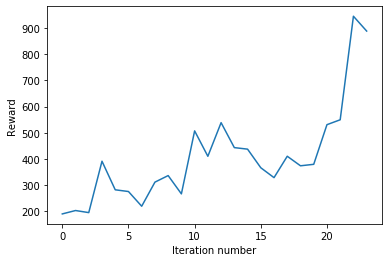

Iteration: 25;   game reward: 895.9101766164126; last timestemp reward: 0.9809182123300487; previous timestamp reward: 0.9963708270303643
Iteration: 26;   game reward: 970.4011696819458; last timestemp reward: 0.9769837013489188; previous timestamp reward: 0.9875175294721756
Iteration: 27;   game reward: 942.1353452719433; last timestemp reward: 0.9348505474653506; previous timestamp reward: 0.9981128210542887
Iteration: 28;   game reward: 951.9785135848591; last timestemp reward: 0.8511501135216945; previous timestamp reward: 0.9994435043562828
Iteration: 29;   game reward: 887.507890223658; last timestemp reward: 0.7923903982517723; previous timestamp reward: 0.9948771399318181
Iteration: 30;   game reward: 329.42057043827396; last timestemp reward: 0.10303795303862044; previous timestamp reward: 0.9943427602578754
Iteration: 31;   game reward: 961.7702840328527; last timestemp reward: 0.962118720613087; previous timestamp reward: 0.9977494828672318
Iteration: 32;   game reward: 963.

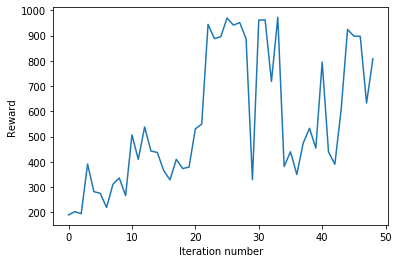

Iteration: 50;   game reward: 966.8405269523589; last timestemp reward: 0.9141103775459405; previous timestamp reward: 0.9975249271906289


In [80]:
num_games = 50

agent,scores, last_rewards, first_rewards = train_model(env, num_games, state_dim, action_spec)

In [65]:
from tensorflow.keras.models import load_model
# target_actor_model = load_model('Swimmer6/target_actor_model.h5')
target_actor_model = load_model('Car/target_actor_model.h5')

In [82]:
from dm_control import suite
from dm_control import viewer
import numpy as np

env = suite.load(domain_name="cartpole", task_name="balance")
action_spec = env.action_spec()
obs_spec = env.observation_spec()

test_games_num = 10
test_scores = []

for game in range(test_games_num):
    score = 0
    step_data = env.reset()  # get initial state 
    obs = convert_state(step_data.observation)
    while not step_data.last():
#         action = np.random.uniform(low=action_spec.minimum,high=action_spec.maximum,size=action_spec.shape) 
        action = agent.target_actor_model.predict(obs)
        step_data = env.step(action[0])
        obs = convert_state(step_data.observation)
        score += step_data.reward
    print(score)   
    test_scores.append(score)

print("Average reward on test 100 games: ", np.mean(test_scores))

948.3544586920299
935.3033950942477
952.1917794584778
934.4530032576189
924.8576642603593
929.0640183378031
935.2792827781539
933.6660300161387
937.3095279401134
938.3589011789763
Average reward on test 100 games:  936.8838061013918


In [ ]:
#Viewer
from dm_control import suite
from dm_control import viewer
import numpy as np

# env = suite.load(domain_name="humanoid", task_name="stand")
env = suite.load(domain_name="cartpole", task_name="balance")
action_spec = env.action_spec()
# print(action_spec)

# Define a uniform random policy.
def random_policy(time_step):
#     del time_step  # Unused.
#     print(target_actor_model.predict(convert_state(time_step)[0]))
#     action = np.random.uniform(low=action_spec.minimum,high=action_spec.maximum,size=action_spec.shape)
    action = agent.target_actor_model.predict(convert_state(time_step.observation))[0]
#     print(action)
    return action
# time_step = env.reset()

# Launch the viewer application.
viewer.launch(env, policy=random_policy)